# 📈 Phase Curve Fitting with Apparition Splitting for FINK Data  
**Milagros Colazo & Dagmara Oszkiewicz**  
📅 *March 2025*  

### 🔍 Overview  
This notebook implements phase curve fitting using apparition splitting for FINK data.

### Reference
Colazo et al. (2025) [Accepted for publication, ICARUS]

### Libraries

In [1]:
import csv
import glob
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import scipy
import warnings

from astropy.time import Time
from astroquery.jplhorizons import Horizons
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from numpy.linalg import LinAlgError
from scipy.interpolate import CubicSpline
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

warnings.filterwarnings('ignore')

### Extracting the data 

In [2]:
r = requests.post(
    'https://api.fink-portal.org/api/v1/sso',
    json={
        'n_or_d': '8467', # Asteroid number
        'withEphem': True, # We need the Phase angle
        'withResiduals': True,
        'output-format': 'json'
    }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

We need to separate the data between filters (g or r). 

In [3]:
pdf = pdf[pdf["i:fid"] == 1] #g only

Our algorithm for apparition identification requires the **elongFlag** from JPL Horizons.  
In this case, I am also downloading the elongation angle for plotting and verifying that everything is working correctly.

In [4]:
ids = 8467  # Small body ID
location = 'I41'  # Observatory code

# Convert Julian dates to TDB
pdf['Date'] = pdf['Date'].astype(float)  # Ensure numerical format
jd_tdb = Time(pdf['Date'].tolist(), format='jd', scale='utc').tdb.value  # Convert UTC to TDB (Horizons ephemeris needs this)

# Get min and max TDB Julian dates
jd_min, jd_max = min(jd_tdb), max(jd_tdb)

# Convert to calendar date format (YYYY-MM-DD)
date_min = Time(jd_min, format='jd', scale='tdb').iso[:10]
date_max = Time(jd_max, format='jd', scale='tdb').iso[:10]

# Query Horizons using the converted TDB time range
obj = Horizons(id=ids, location=location, epochs={'start': date_min, 'stop': date_max, 'step': '1d'}, id_type='smallbody')
eph = obj.ephemerides()

# Convert ephemeris data to Pandas DataFrame
eph_df = eph.to_pandas()

# Convert ephemeris dates from UTC to TDB before merging
eph_df['JD_TDB'] = Time(eph_df['datetime_jd'].tolist(), format='jd', scale='utc').tdb.value  

# Merge on the closest Julian date
pdf = pd.merge_asof(pdf.sort_values('Date'), eph_df[['JD_TDB', 'elongFlag', 'elong']].sort_values('JD_TDB'),
                    left_on='Date', right_on='JD_TDB', direction='nearest')

pdf.drop(columns=['JD_TDB'], inplace=True)  # Remove helper column

_____________

### Apparition identification

In [5]:
def split_dataframe_on_value_change(df, column_name,time_column):
    df_list = []
    temp_df = None
    prev_value = None
    prev_time = None

    for index, row in df.iterrows():
        current_value = row[column_name]
        current_time = row[time_column]

        if current_value.startswith('/L') and (prev_value is None or prev_value.startswith('/T')):
            if temp_df is not None and not temp_df.empty:
                df_list.append(temp_df)
            temp_df = pd.DataFrame(columns=df.columns)
        elif current_value.startswith('/T') and (prev_value is None or prev_value.startswith('/L')):
            if temp_df is None:
                temp_df = pd.DataFrame(columns=df.columns)
        elif current_value.startswith('/T') and prev_value.startswith('/T'):
            current_time = row[time_column]  # Extract the Julian date from the current row.
            if prev_time is not None and (current_time - prev_time) > 182.5:
                # If the difference is greater than 6 months, a new apparition begins.
                df_list.append(temp_df)
                temp_df = pd.DataFrame(columns=df.columns)  
            if temp_df is None:
                temp_df = pd.DataFrame(columns=df.columns)

        if temp_df is not None:
            temp_df = pd.concat([temp_df, row.to_frame().T], ignore_index=True)

        # Update previous values
        prev_value = current_value
        prev_time = current_time 

    if temp_df is not None and not temp_df.empty:
        df_list.append(temp_df)

    return df_list

Here we apply the function

In [6]:
splitted = split_dataframe_on_value_change(pdf, 'elongFlag', 'Date')

In [7]:
# How many apparitions have we identified?
len(splitted)

3

A plot to verify whether we are correctly identifying the apparitions

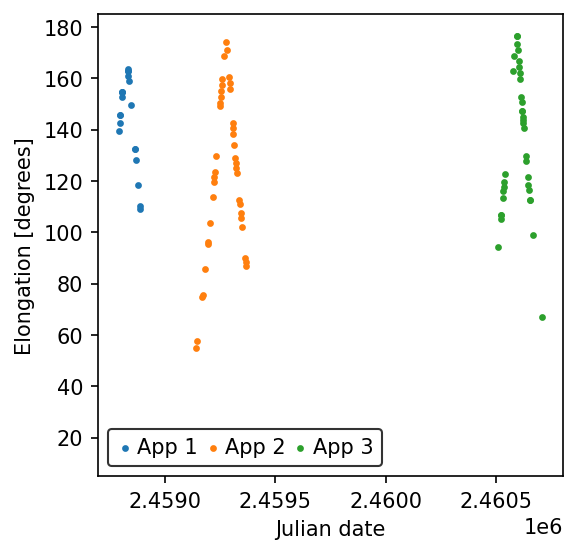

In [8]:
plt.figure(figsize=(4, 4), dpi=150)

plt.scatter(splitted[0].Date, splitted[0].elong, s=5, label='App 1')
plt.scatter(splitted[1].Date, splitted[1].elong, s=5, label='App 2')
plt.scatter(splitted[2].Date, splitted[2].elong, s=5, label='App 3')

plt.xlabel('Julian date')
plt.ylabel('Elongation [degrees]')

plt.ylim(5,185)

plt.legend(facecolor='none', edgecolor='black',loc='lower left', 
                    ncols=5, handletextpad=0.2, columnspacing=0.3, handlelength=0.8)

The phase curve

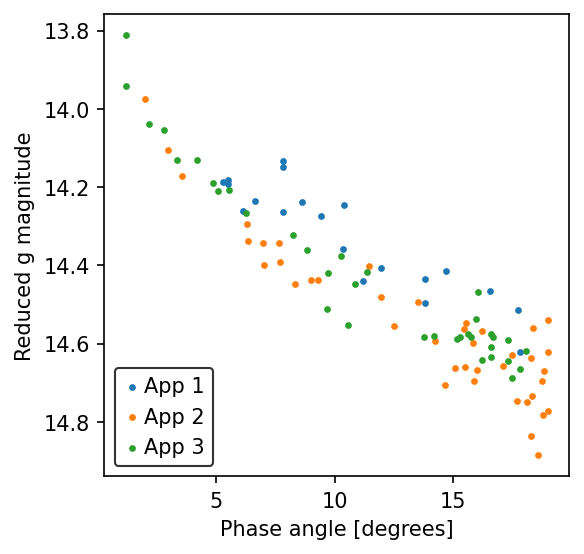

In [9]:
plt.figure(figsize=(4, 4), dpi=150)

plt.gca().invert_yaxis()
plt.scatter(splitted[0].Phase, splitted[0]['i:magpsf_red'], s=5, label='App 1')
plt.scatter(splitted[1].Phase, splitted[1]['i:magpsf_red'], s=5, label='App 2')
plt.scatter(splitted[2].Phase, splitted[2]['i:magpsf_red'], s=5, label='App 3')

plt.xlabel('Phase angle [degrees]')
plt.ylabel('Reduced g magnitude')

#plt.ylim(5,185)

plt.legend(facecolor='none', edgecolor='black',loc='lower left', 
                    ncols=1, handletextpad=0.2, columnspacing=0.3, handlelength=0.8)

________________

### Phase curve fitting

Definition of the functions

In [10]:
knot_alpha = [np.radians(np.array([7.5, 30.0, 60.0, 90.0, 120.0, 150.0])),
                  np.radians(np.array([0.0, 0.3, 1.0, 2.0, 4.0, 8.0, 12.0, 20.0, 30.0]))]
knot_phi = [np.array([7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2, 3.6396989e-3]),
                np.array([9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2, 1.6505689e-4]),
                np.array([1.0, 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1, 1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.0])]

cs = [CubicSpline(knot_alpha[0], knot_phi[0], bc_type=((1, -6.0/np.pi),(1, -9.1328612e-2))),
          CubicSpline(knot_alpha[0], knot_phi[1], bc_type=((1, -9.0/(5.0*np.pi)),(1, -8.6573138e-8))),
          CubicSpline(knot_alpha[1], knot_phi[2], bc_type=((1, -0.10630097),(1, 0.0)))]

def phi1(alp):
    if alp > 0 and alp <= 7.5:
        return 1.0-6.0/np.pi*np.radians(alp)
    elif alp > 7.5 and alp <= 150.0:
        return cs[0](np.radians(alp))

def phi2(alp):
    if alp > 0 and alp <= 7.5:
        return 1.0-9.0/(5.0*np.pi)*np.radians(alp)
    elif alp > 7.5 and alp <= 150:
        return cs[1](np.radians(alp))

def phi3(alp):
    if alp > 0 and alp <= 30.0:
        return cs[2](np.radians(alp))
    elif alp > 30 and alp <= 150:
        return 0.0
        
def basis_function(num, alpha):
    val = []
    for a in alpha:
        if num == 1:
            val.append(phi1(a))
        elif num == 2:
            val.append(phi2(a))
        else:
            val.append(phi3(a))
    return np.array(val)

def HG1G2_non_lin(alpha, H, G1, G2):
    return (10**(-0.4*H))*(G1*basis_function(1, alpha)+G2*basis_function(2, alpha)+(1-G1-G2)*basis_function(3, alpha))
    
def HG1G2_multiple(alps, G1, G2, *args):
    fl = []
    for alpha, H in zip(alps, args[0][:]):
        fl.append(HG1G2_non_lin(alpha, H, G1, G2))    
    return np.concatenate(fl)

def HG1G2_error_fun(params, alphas, flux): 
    return HG1G2_multiple(alphas, params[0], params[1], params[2:]) - flux

def fit_HG1G2(fluxes, alpha_table, max_mags):
    popt = least_squares(HG1G2_error_fun, x0=[0.1, 0.1, *max_mags], loss='huber', method='trf', args=[alpha_table, fluxes],
                         xtol=1e-20, gtol=1e-17)   
    # Result
    params = popt.x 
    G1 = params[0]
    G2 = params[1]
    H = params[2:]

    # Uncertainities
    J = popt.jac
    cov = np.linalg.inv(J.T.dot(J))
    std = np.sqrt(np.diagonal(np.linalg.inv(J.T @ J) * (popt.fun.T @ popt.fun / (popt.fun.size - popt.x.size))))
    
    print('H apparitions: ', H, 'G1: ', G1, 'G2: ', G2, 'uncertainities: ', std)
    return H, G1, G2, std

In [11]:
# Output CSV file
output_csv = "/home/milagros/Desktop/OPUS/pcfit_ztf_test.csv" # We save the results here

# Open the CSV file for appending and write the header if it doesn't exist
file_exists = os.path.isfile(output_csv)

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    tables_of_tables = [] # List to hold all DataFrames
    max_mag = []  # Maximum magnitude per apparition
    alpha_values = []  # List to hold alpha values for current df
    tables_in_folder = []
        
    for df in splitted:
        alpha_lists = []  # List to hold lists of alpha values
        df_original = df
   
        m = df_original['i:magpsf_red'].to_numpy()
        flux = np.power(10.0, -0.4 * m)
        df_original.insert(4, "flux_red", flux, True)
        
        maximum = df_original['i:magpsf_red'].max()
        
        max_mag.append(maximum)
        alpha_values.append(df_original['Phase'].to_numpy())
        tables_in_folder.append(df_original)

    # Concatenate all DataFrames into one
    tables_of_tables.append(tables_in_folder)
    
    # Append lists of alpha and flux values for current folder to the main lists
    alpha_lists.append(alpha_values)
    
    flux_lists = []
    for table in tables_of_tables:
        table_flux = []
        for df in table:
            # Extract 'flux' columns and convert to lists
            flux = df['flux_red'].values.tolist()
            table_flux.extend(flux)
        flux_lists.append(table_flux)

    try:
        idd = '8467' 
        
        # Fit using PCFit
        H, G1, G2, std = fit_HG1G2(flux_lists[0], alpha_lists[0], max_mag)
        G1_error = std[0]
        G2_error = std[1]
        H_error = std[2:]
        
        # Save the results to the CSV file
        writer.writerow([idd, H, H_error, G1, G1_error, G2, G2_error])
        print(f"DONE {idd}")
        
    except LinAlgError as e:
        print(f"LinAlgError processing folder {folder_path}: {e}")

H apparitions:  [13.50425483 13.63401574 13.59724012] G1:  0.15586030324387667 G2:  0.36621195298169595 uncertainities:  [0.06142343 0.02800531 0.04651104 0.04260641 0.0399605 ]
DONE 8467
